# Implementing Research Paper:  Fraud Detection in Mobile Payment Systems using an XGBoost‑based Framework
https://doi.org/10.1007/s10796-022-10346-6

In [1]:
!pip install pyod 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.8 MB/s eta 0:00:00


In [73]:
!pip install alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 14.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 54.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 14.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: attrs
    Found existing installation: attrs 25.3.0
    Uninstalling attrs-25.3.0:
      Successfully uninstalled attrs-25.3.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.1
    Uninstalling scikit-image-0.25.1:
      Successfully uninstalled scikit-image-0.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages t

In [74]:
!pip install lime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [237]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.loda import LODA
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.xgbod import XGBOD

from alibi.explainers import ALE, plot_ale

from lime.lime_tabular import LimeTabularExplainer

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

## Dataset Loading and Preparation

In [4]:
data = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
drop_features = ["nameOrig", "nameDest", "isFlaggedFraud"]
data.drop(columns=drop_features, inplace=True)

In [6]:
type_one_hot = pd.get_dummies(data["type"], prefix="type_")
data_without_type = data.drop(columns=["type"])
data = pd.concat([type_one_hot, data_without_type], axis=1)

In [51]:
sample_size = 100000
idx = np.random.choice(data.index, sample_size)

In [52]:
X = data.drop(columns=["isFraud"]).loc[idx]
y = data[["isFraud"]].loc[idx]

In [53]:
X.head()

,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
5315046,False,False,False,True,False,374,13952.52,100834.00,86881.48,0.00,0.00
5618203,True,False,False,False,False,395,260464.50,150.00,260614.50,565551.63,305087.13
4743173,True,False,False,False,False,332,199335.98,10136051.31,10335387.29,340688.26,141352.28
1666081,False,True,False,False,False,158,239988.03,159661.05,0.00,511096.89,751084.92
3419387,True,False,False,False,False,256,92380.17,75473.00,167853.17,4160168.22,4067788.05


In [54]:
y.head()

,isFraud
5315046,0
5618203,0
4743173,0
1666081,0
3419387,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Model Preparation

In [56]:
outlier_percentage = y_train.value_counts().iloc[1] / len(y_train)
outlier_percentage

0.0012933333333333334

In [57]:
unsupervised_estimators = []
unsupervised_estimators.append(CBLOF(n_clusters=8, alpha=0.9))
unsupervised_estimators.append(HBOS(alpha=0.1))
unsupervised_estimators.append(LODA(n_bins=10, n_random_cuts=100))
unsupervised_estimators.append(MCD(contamination=outlier_percentage))
unsupervised_estimators.append(AutoEncoder(hidden_activation_name="relu", optimizer_name="adam", epoch_num=100, dropout_rate=0.2, hidden_neuron_list=[8, 4, 4, 8], optimizer_params={"weight_decay": 0.2}))
unsupervised_estimators.append(VAE(hidden_activation_name="relu", optimizer_name="adam", epoch_num=100, dropout_rate=0.2, optimizer_params={"weight_decay": 0.1}, beta=1.0, encoder_neuron_list=[8, 4, 2], decoder_neuron_list=[2, 4, 8]))

In [58]:
for n_neighbors in [5, 10]:
    unsupervised_estimators.append(ABOD(contamination=outlier_percentage, n_neighbors=n_neighbors))

In [59]:
for n_estimators in [100, 200]:
    unsupervised_estimators.append(IForest(n_estimators=n_estimators))

In [60]:
for n_neighbors in [2, 3, 5]:
    unsupervised_estimators.append(KNN(n_neighbors=n_neighbors))

In [61]:
for kernel in ["linear", "poly", "rbf"]:
    kwargs = {"kernel": kernel, "nu":0.1}
    if kernel == "rbf":
        kwargs["gamma"] = 0.01
    unsupervised_estimators.append(OCSVM(**kwargs))

In [62]:
model = XGBOD(estimator_list=unsupervised_estimators, learning_rate=0.1, silent=False)

## Model Training

In [63]:
model.fit(X_train, y_train)

Training: 100%|██████████| 100/100 [10:23<00:00,  6.23s/it]


XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False), HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5), LODA(contamination=0.1, n_bins=10, n_random_cuts=100), MCD(ass...e=3, gamma=0.01,
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, n_estimators=100, n_jobs=1, nthread=None,
   objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1,
   scale_pos_weight=1, silent=False,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True],
   subsample=1)

In [64]:
y_pred = model.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred, target_names=["Normal", "Fraud"]))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     24965
       Fraud       0.92      0.63      0.75        35

    accuracy                           1.00     25000
   macro avg       0.96      0.81      0.87     25000
weighted avg       1.00      1.00      1.00     25000



## Model interpretation

In [133]:
def predict_proba(samples):
    pred = model.predict_proba(samples)
    probs = []
    for i in range(len(pred)):
        probs.append([1 - pred[i], pred[i]])
    return np.array(probs)

### LIME

In [100]:
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_test.columns.tolist(), class_names=["Normal", "Fraud"])

In [141]:
lime_explaination_1 = lime_explainer.explain_instance(X_test.iloc[0], predict_proba, num_features=11, num_samples=1000)
lime_explaination_1.show_in_notebook()

In [142]:
lime_explaination_2 = lime_explainer.explain_instance(X_test.iloc[384], predict_proba, num_features=11, num_samples=1000)
lime_explaination_2.show_in_notebook()

### ALE

In [167]:
ale_explainer = ALE(predict_proba, feature_names=X_test.columns.tolist(), target_names=["Normal", "Fraud"])

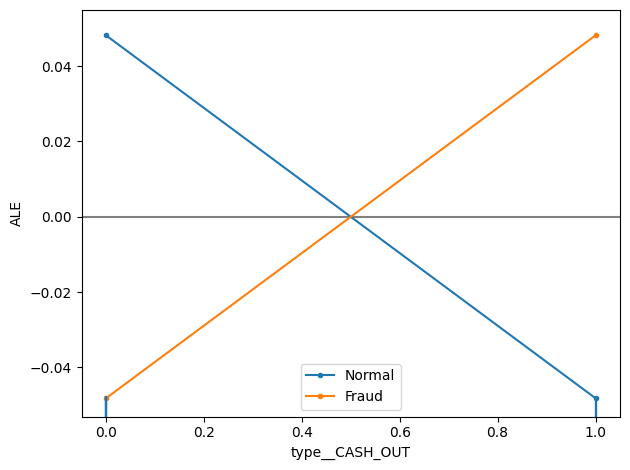

In [170]:
ale_explaination_1 = ale_explainer.explain(X_test.values[:1000], features=[1])
plot_ale(ale_explaination_1)
plt.show()

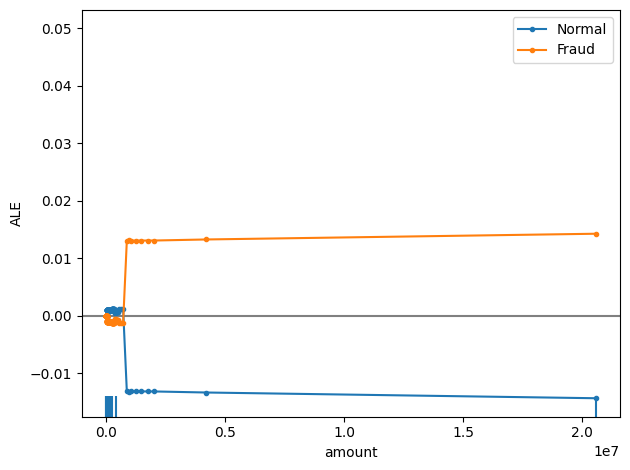

In [249]:
ale_explaination_2 = ale_explainer.explain(X_test.values[:1000], features=[6])
plot_ale(ale_explaination_2)
plt.show()

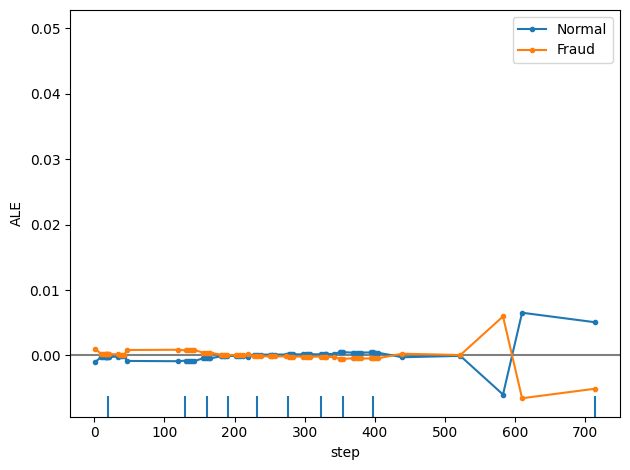

In [176]:
ale_explaination_3 = ale_explainer.explain(X_test.values[:1000], features=[5])
plot_ale(ale_explaination_3)
plt.show()

### PFI

In [212]:
def scoring(model, X_test, y_test):
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred)

In [215]:
pfi_scores = permutation_importance(model, X_test.iloc[:1000], y_test[:1000], scoring=scoring)

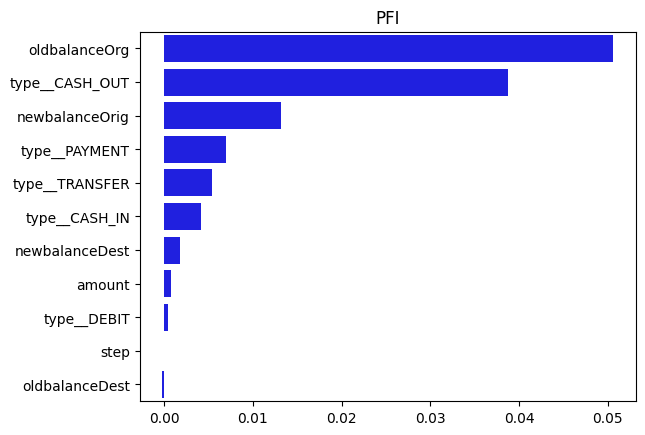

In [235]:
idx = pfi_scores.importances_mean.argsort()[-1::-1]
sns.barplot(x=pfi_scores.importances_mean[idx], y=X_test.columns.values[idx], orient="h", color="blue")
plt.title("PFI")
plt.show()

### Global Surrogate Model

In [245]:
gsm_model = DecisionTreeClassifier(max_depth=4)
gsm_model.fit(X_test, y_pred)

DecisionTreeClassifier(max_depth=4)

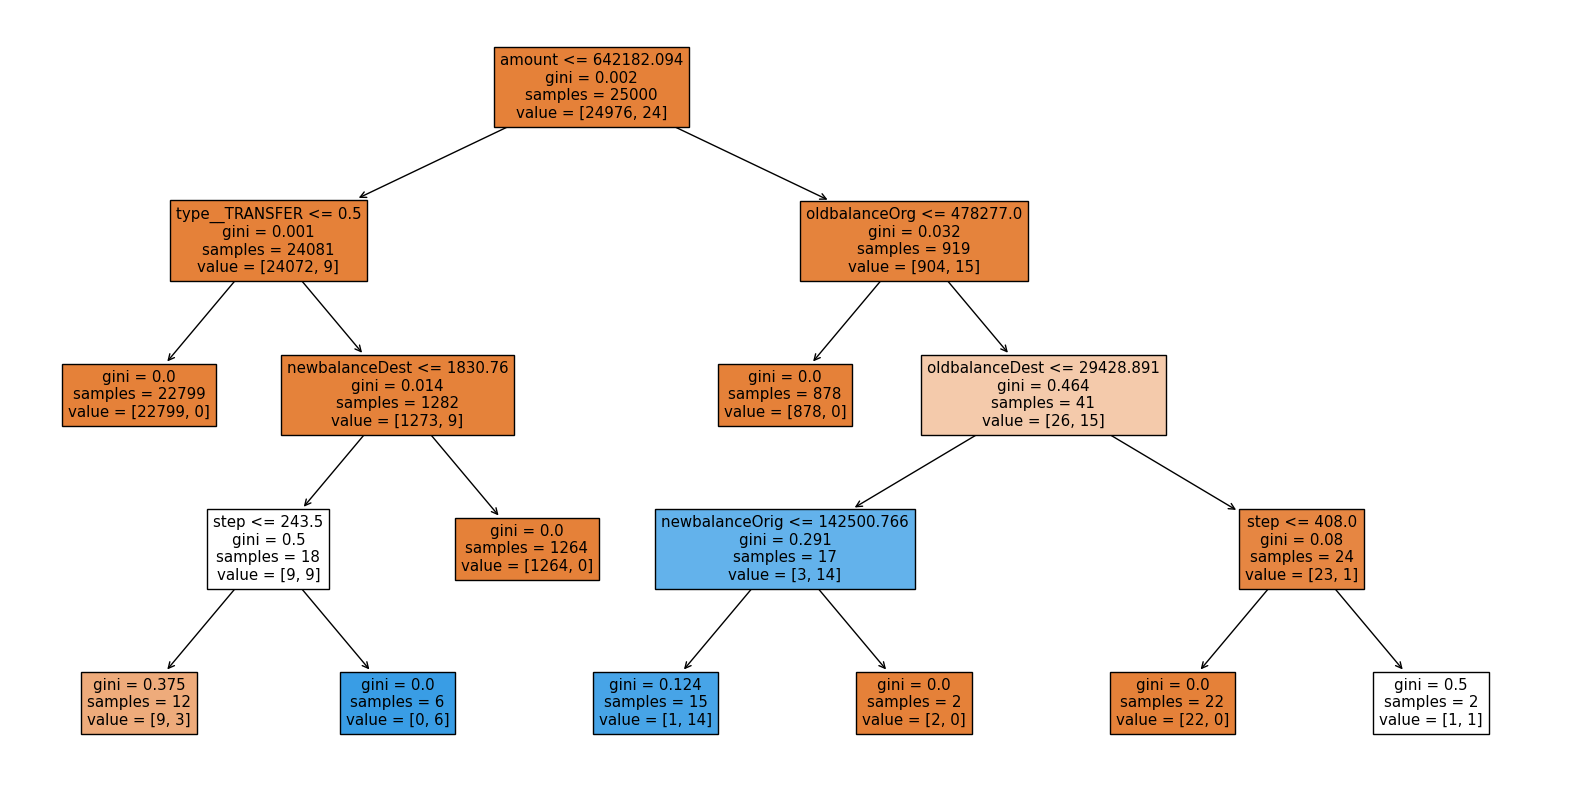

In [247]:
plt.figure(figsize=(20,10))
plot_tree(gsm_model, feature_names=X_test.columns, filled=True)
plt.show()

## Discussion

The model achieved acceptable performance, considering that it was trained on less than 2% of the original training set used in the proposed work, due to our limited computational resources. However, the most significant drawback was a decrease of approximately 0.15 in recall. According to the results reported in the original paper, training the model on the full dataset leads to superior performance compared to other models.

To interpret the model, we adopted four model-agnostic methods due to its complexity. These methods included:

- LIME, to explain one fraudulent and one non-fraudulent example;
- ALE, to evaluate the effect of key features on predictions;
- PFI (Permutation Feature Importance), to compare feature importance across the model;
- Decision tree training as a Global Surrogate Model (GSM) to gain a high-level understanding of model behavior.

The GSM decision tree visualizations suggest that most frauds occur when the transaction amount is high, the victim has a high balance before the transaction, and the thief has a low balance before the transaction. The "old balance" and the occurrence of a "cash out" transaction emerged as the most influential features according to permutation feature importance, which aligns with the insights from the GSM. This is reasonable, as "cash out" typically represents a transfer from the victim’s account to the thief’s. The influence of "cash out" and "amount" was further confirmed by ALE, which indicated their significant impact on the model’s predictions. ALE also revealed that the "step" (time) feature affects the model’s output and interacts with other features, as its effect does not follow a single trend.

When using LIME to explain a non-fraudulent transaction, we found that the model based its decision primarily on the balances of both the victim and thief before the transaction, as well as the transaction type ("cash out"). In contrast, when explaining a fraudulent example, the model relied mostly on the victim's balance before and after the transaction values that correspond to the transaction amount and again the "cash out" transaction type.